# Towards Gaussian simulation

Today we are applying Simple Kriging to a subset of our well log data. We are also performing first steps towards Sequential Gaussian Simulation.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Extracting random values from the dataset.

We will work with our reduced and detrended dataset again today. Until now we used on the full dataset - let's now assume we actually only have a measurement every 50 ft instead of every 0.5 ft. Here a way to extract this subset of data. We end up with a new dataframe containing a lot less data.

So we need some (geo-)fantasy now. Imagine the full dataset is our **Underlying truth** - the real distribution of our property in the subsurface. The data subset is our measured data - and we want to try to fill the space between the measurements using kriging.

In [2]:
# loading data as usual
data = pd.read_csv('data_detr.csv')

In [3]:
# Extracting value every 50 ft
data_subset = data.iloc[np.arange(0,len(data['DEPT']),50)]

Text(0.5, 0, 'DT')

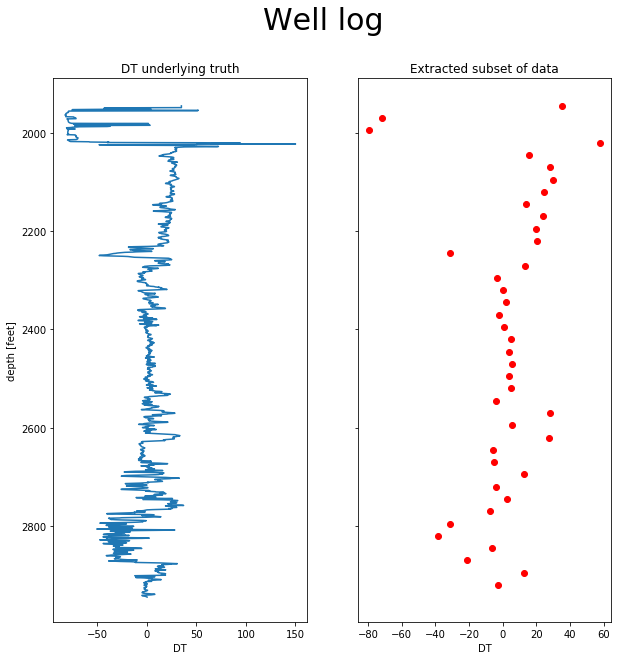

In [4]:
# And one possible solution for plotting
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10), sharey=True)
fig.suptitle("Well log", fontsize=30)

ax01=ax[0]
ax01.set_title('DT underlying truth')
ax01.invert_yaxis()
ax01.plot(data['DT'], data['DEPT'])
ax01.set_xlabel('DT')
ax01.set_ylabel('depth [feet]')

ax02=ax[1]
ax02.set_title('Extracted subset of data')
ax02.scatter(data_subset['DT'], data_subset['DEPT'], color='r')
ax02.set_xlabel('DT')

In [5]:
data_subset.head()

,DEPT,DT
0,1945.5,34.979732
50,1970.5,-71.444692
100,1995.5,-79.208717
150,2020.5,57.698459
200,2045.5,15.565834


In [6]:
len(data_subset)

40

### Covariance function

Let's quickly take a look at a covariance function again - using roughly the estimates for *range* and *sill* from last sessions varigoram analysis. We apply the *exponential covariance model*.


In [7]:
def cf(h, range_=80, sill=600):
    c = sill*np.exp(-(np.abs(h)/range_))
    return c

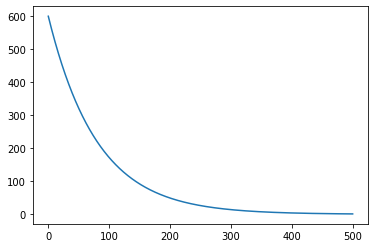

In [8]:
x = np.arange(0,500,0.1)
y = cf(x)
plt.plot(x,y)

### Kriging interpolation

Let's now perform Simple Kriging to fill the empty space.

<div class='alert alert-info'>
    
**Your task**: Extend your Simple Kriging function that you created a couple of sessions ago to perform the Kriging interpolation for unknown locations based on the `data_subset`. You probably to adjust your code for building the matrices in order to build the matrices here (remember how the size of those matrices is defined).
</div>

Test your implementation for a singel unknown position. If you are confident that it works, can you set up a loop to interpolate over the whole depth range of the borehole? Plot your result!

In [9]:
# SOLUTION
def kriging(pos_unknown, x_pos, vals, r, sample_mean, sample_var):
    '''Performs simple kriging with multiple points
    
    **Arguments**:
        pos_unknown: position of unknown value
        x_pos : numpy array with positions of known values (used for interpolation)
        vals : numpy array corresponding property values at known positions
        r : variogram range
        sample_mean : mean value of sample population
        sample_var : variance of sample population
    
    **Returns**:
        estimated_val, estimated_var : estimated value and variance
    '''
    n = len(x_pos)
    C = np.ones((n,n))
    c = np.ones(n)
    for i in range(n):
        c[i] = cf(x_pos[i]-pos_unknown)
        j = 0
        while j < n:
            C[i,j] = cf(x_pos[i]-x_pos[j])
            j += 1
    
    w = np.linalg.solve(C,c)
                                 
    estimated_val = sample_mean + np.sum(w*(vals-sample_mean))
    
    estimated_var = cf(0)-np.sum(w*c)
                               
    return estimated_val
    

In [10]:
# unknown_position = 2000
x_pos = (data_subset['DEPT']).values
vals = (data_subset['DT']).values
sample_mean = np.mean(vals)
sample_var = np.var(data_subset['DT'])
# kriging(unknown_position, x_pos, vals, 80, sample_mean, sample_var)

In [11]:
np.min(x_pos)

1945.5

In [12]:
x_pos.max()

2920.5

In [13]:
result = []

for i in range(int(np.min(x_pos)), int(np.max(x_pos))):
    temp = kriging(i, x_pos, vals, 80, sample_mean, sample_var)
    result.append(temp)

Text(0.5, 0, 'DT')

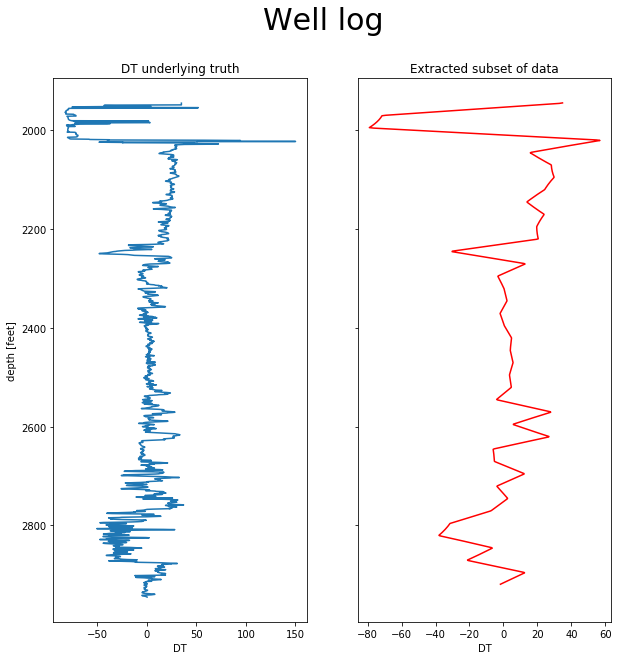

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10), sharey=True)
fig.suptitle("Well log", fontsize=30)

ax01=ax[0]
ax01.set_title('DT underlying truth')
ax01.invert_yaxis()
ax01.plot(data['DT'], data['DEPT'])
ax01.set_xlabel('DT')
ax01.set_ylabel('depth [feet]')

ax02=ax[1]
ax02.set_title('Extracted subset of data')
ax02.plot(result, range(int(x_pos.min()), int(x_pos.max())), color='r')
ax02.set_xlabel('DT')

In [15]:
np.var(data_subset['DT'])

652.914330808025

### How to tackle missing variance effect?

Hopefully you now see the effect of the missing variance in this example. In order to get rid of this "smoothing" we have to incorporate the kriging variance. Let's do it for a single unknown location:

In [16]:
# YOUR CODE HERE

# Extend your kriging function to include calculating kriging variance
def kriging_var(pos_unknown, x_pos, vals, r, sample_mean):

    n = len(x_pos)
    C = np.ones((n,n))
    c = np.ones(n)
    for i in range(n):
        c[i] = cf(x_pos[i]-pos_unknown)
        j = 0
        while j < n:
            C[i,j] = cf(x_pos[i]-x_pos[j])
            j += 1
    
    w = np.linalg.solve(C,c)
    
    estimated_var = cf(0)-np.sum(w*c)
                               
    return estimated_var
# Based on this, use your function to calcualte estimate and variance for a singel unknown location

# Draw a random value from a normal distribution for this unknown location based on the calculated estimate and variance
# x = np.random.normal(0, 1, size=(len(data_subset)))
# This is one substep of Sequential Gaussuan Simulation (SGS) - feel free to continue

In [25]:
kr_var_result = []
for i in range(int(np.min(x_pos)), int(np.max(x_pos))):
    kr_var = kriging_var(i, x_pos, vals, 80, sample_mean)
    kr_var_result.append(kr_var)
    
   

In [32]:
# kr_var_result

Text(0.5, 0, 'DT')

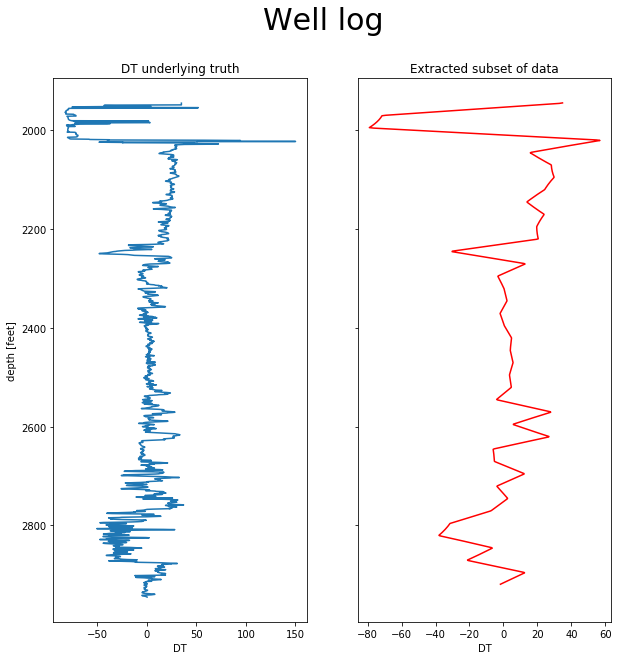

In [19]:
result1 = []

for i in range(int(np.min(x_pos)), int(np.max(x_pos))):
    temp = kriging(i, x_pos, vals, 80, sample_mean, kr_var)
    result1.append(temp)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10), sharey=True)
fig.suptitle("Well log", fontsize=30)

ax01=ax[0]
ax01.set_title('DT underlying truth')
ax01.invert_yaxis()
ax01.plot(data['DT'], data['DEPT'])
ax01.set_xlabel('DT')
ax01.set_ylabel('depth [feet]')

ax02=ax[1]
ax02.set_title('Extracted subset of data')
ax02.plot(result1, range(int(x_pos.min()), int(x_pos.max())), color='r')
ax02.set_xlabel('DT')

Text(0, 0.5, 'DEPT')

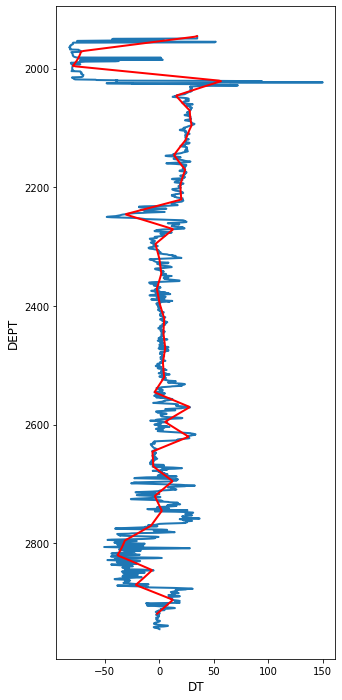

In [20]:
plt.figure(figsize=(5,12))
plt.plot(data['DT'], data['DEPT'],result1, range(int(x_pos.min()), int(x_pos.max())), 'r', linewidth=2)
plt.gca().invert_yaxis()
plt.xlabel('DT', fontsize=12)
plt.ylabel('DEPT', fontsize=12)